# Visualizer and Plotter

Notebook to create the images used in the report


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy import signal
from torch.utils.data import DataLoader

from dataset import CHBMITDataset

data_path = "./CHB-MIT/processed"
dataset = CHBMITDataset(data_path)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [2]:
def plot_coding(original_data, spike_data, decoded_data):
    figs, axes = plt.subplots(3, 1, figsize=(10, 8))
    figs.set_tight_layout(True)
    axes[0].set_title("Encoded Spike Train")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Spike")
    axes[0].stem(spike_data, markerfmt="none")
    axes[1].set_title("Original Signal")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Amplitude")
    sns.lineplot(original_data, ax=axes[1])
    axes[2].set_title("Decoded Signal")
    axes[2].set_xlabel("Timesteps")
    axes[2].set_ylabel("Amplitude")
    sns.lineplot(decoded_data, ax=axes[2])

<Axes: >

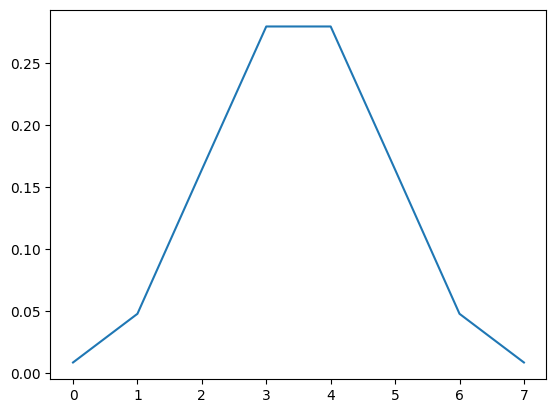

In [3]:
filter_w = signal.firwin(8, cutoff=0.2)
filter_w = torch.tensor(filter_w, dtype=torch.float32)
sns.lineplot(filter_w)

In [6]:
sample_data, sample_label = next(iter(data_loader)) 

In [7]:
import torch

from utils.preprocess import VectorizeSTFT

stft_data = VectorizeSTFT(sample_data)
magnitudes = torch.abs(stft_data)

In [8]:
def normalize(x: torch.Tensor) -> torch.Tensor:
    x_min = x.min(dim=-1, keepdim=True).values
    x_max = x.max(dim=-1, keepdim=True).values

    diff = x_max - x_min
    diff[diff == 0] = 1.0

    return (x - x_min) / diff

In [9]:
norm_magnitudes = normalize(magnitudes)

In [61]:
win_size = 8
cutoff = 0.2
threshold = 0.1

batch, channels, freqs, time_steps = norm_magnitudes.shape
        
# Reshape for processing
x_reshaped = norm_magnitudes.reshape(batch * channels * freqs, time_steps)

# Create output tensor and working copy
spike_train = torch.zeros_like(x_reshaped)
x_clone = x_reshaped.clone()

# Create tiled filter window
filter_window = torch.tensor(signal.firwin(win_size, cutoff=cutoff), dtype=torch.float32, device=norm_magnitudes.device)
filter_w = filter_window.expand(batch * channels * freqs, win_size)

# Vectorized encoding
for t in range(time_steps - win_size + 1):
    window_slice = x_clone[:, t:t + win_size]
    error1 = torch.abs(window_slice - filter_w).sum(dim=1)
    error2 = torch.abs(window_slice).sum(dim=1)
    
    mask = error1 <= error2 - threshold
    spike_train[mask, t] = 1
    x_clone[mask, t:t + win_size] -= filter_w[mask]

In [121]:
spike_out = spike_train.reshape(batch, channels, freqs, time_steps)

In [ ]:
def bsa_encode(x: np.ndarray, filter_window: np.ndarray, threshold: float) -> np.ndarray:
    """
    Binary Spike Encoding (BSA) for a 1D signal.
    """
    signal_length = x.shape[0]
    spikes = np.zeros_like(x)

    for t in range(signal_length - len(filter_window) + 1):
        error1 = np.abs(x[t:t + len(filter_window)] - filter_window).sum()
        error2 = np.abs(x[t:t + len(filter_window)]).sum()

        if error1 <= error2 - threshold:
            spikes[t] = 1
            x[t:t + len(filter_window)] -= filter_window

    return spikes

In [66]:
filter_window.view(1, 1, -1).shape

torch.Size([1, 1, 8])

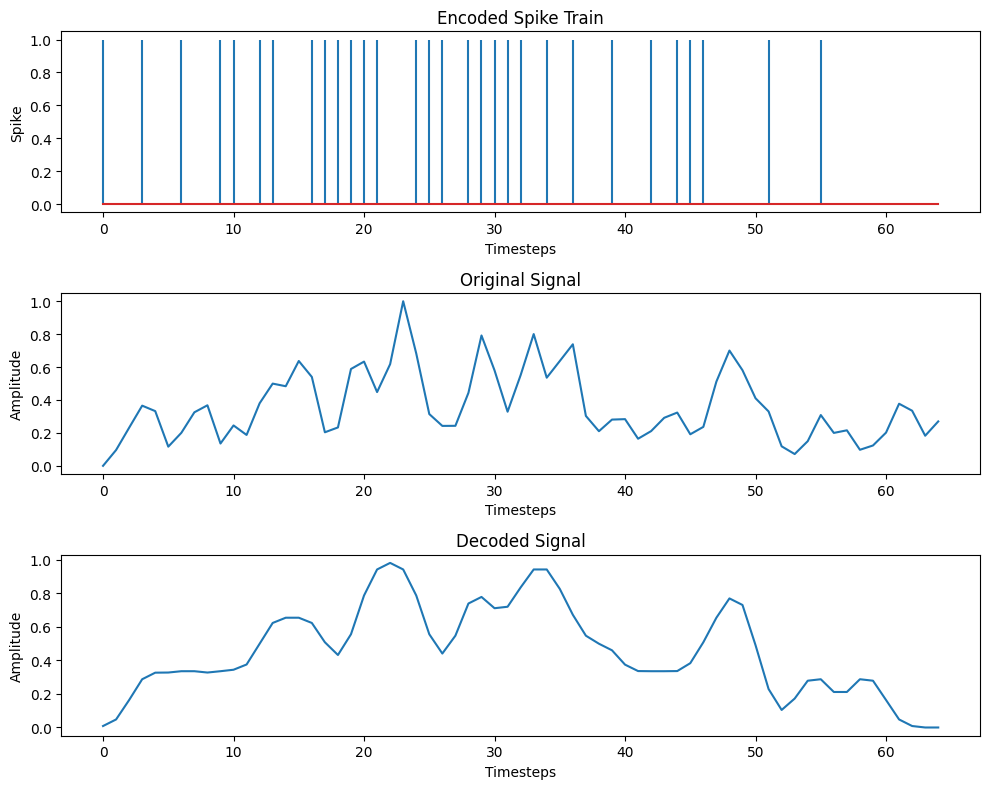

In [154]:
b = 0
c = 10
f = 10
plot_coding(norm_magnitudes[b,c,f], spike_out[b,c,f], decoded_data[b,c,f])

In [73]:
windows_size = 4
cutoff = 0.2
threshold = 0.5
spike = bsa_encode_np(norm_magnitudes[0, 1, 100], windows_size, cutoff, threshold)

In [77]:
out_spike = spikes.reshape(batch, channels, freqs, time_steps)
out_spike[b, c, f]

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [74]:
spike

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [71]:
def bsa_encode_np(data, win_size=8, cutoff=0.2, threshold=0.95):
    # Create filter window
    filter_window = signal.firwin(win_size, cutoff=cutoff)

    # Encoding
    signal_length = data.shape[0]
    bsa_spikes = np.zeros_like(data)
    signal_copy = np.copy(data)

    for t in range(signal_length - win_size + 1):
        error1 = 0
        error2 = 0

        for k in range(win_size):
            error1 += np.abs(signal_copy[t + k] - filter_window[k])
            error2 += np.abs(signal_copy[t + k])

        if error1 <= error2 - threshold:
            bsa_spikes[t] = 1
            for k in range(win_size):
                if t + k < signal_length:
                    signal_copy[t + k] -= filter_window[k]
    return bsa_spikes

In [ ]:
from scipy import signal


def bsa_encode_decode(data, win_size=8, cutoff=0.2, threshold=0.95):
    # Create filter window
    filter_window = signal.firwin(win_size, cutoff=cutoff)

    # Encoding
    signal_length = data.shape[0]
    bsa_spikes = np.zeros_like(data)
    signal_copy = np.copy(data)

    for t in range(signal_length - win_size + 1):
        error1 = 0
        error2 = 0

        for k in range(win_size):
            error1 += np.abs(signal_copy[t + k] - filter_window[k])
            error2 += np.abs(signal_copy[t + k])

        if error1 <= error2 - threshold:
            bsa_spikes[t] = 1
            for k in range(win_size):
                if t + k < signal_length:
                    signal_copy[t + k] -= filter_window[k]

    # Decoding
    reconstructed = np.convolve(bsa_spikes, filter_window, mode="full")
    reconstructed = reconstructed[:signal_length]

    return bsa_spikes, reconstructed

In [ ]:
def objective(trial: optuna.Trial) -> float:
    win_size = trial.suggest_int("win_size", 1, 16)
    cutoff = trial.suggest_float("cutoff", 0.05, 0.3)  # Narrower range
    threshold = trial.suggest_float("threshold", 0.1, 1.5)  # Wider range

    _, decoded = bsa_encode_decode(
        normalized_data, win_size=win_size, cutoff=cutoff, threshold=threshold
    )

    # Calculate loss (Mean Squared Error)
    loss = np.mean((decoded - normalized_data) ** 2)
    return loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-06 18:21:08,276] A new study created in memory with name: no-name-86dcddae-bf49-426f-8d7e-612ebd8661ab
[I 2025-04-06 18:21:08,281] Trial 0 finished with value: 0.0328999055566634 and parameters: {'win_size': 2, 'cutoff': 0.21442513833026894, 'threshold': 0.6038104469162364}. Best is trial 0 with value: 0.0328999055566634.
[I 2025-04-06 18:21:08,283] Trial 1 finished with value: 0.06746908198956465 and parameters: {'win_size': 2, 'cutoff': 0.161174909604562, 'threshold': 0.904579745421133}. Best is trial 0 with value: 0.0328999055566634.
[I 2025-04-06 18:21:08,288] Trial 2 finished with value: 0.007485972807083017 and parameters: {'win_size': 9, 'cutoff': 0.2635208328696855, 'threshold': 0.7162340228401114}. Best is trial 2 with value: 0.007485972807083017.
[I 2025-04-06 18:21:08,292] Trial 3 finished with value: 0.3241285775537164 and parameters: {'win_size': 3, 'cutoff': 0.21677743663781118, 'threshold': 1.2265262185213084}. Best is trial 2 with value: 0.007485972807083017.

In [237]:
win_size = study.best_trial.params["win_size"]
cutoff = study.best_trial.params["cutoff"]
threshold = study.best_trial.params["threshold"]

bsa_spikes, bsa_decoded = bsa_encode_decode(
    normalized_data, win_size=win_size, cutoff=cutoff, threshold=threshold
)

<Axes: title={'center': 'Decoded Signal'}, xlabel='Timesteps', ylabel='Amplitude'>

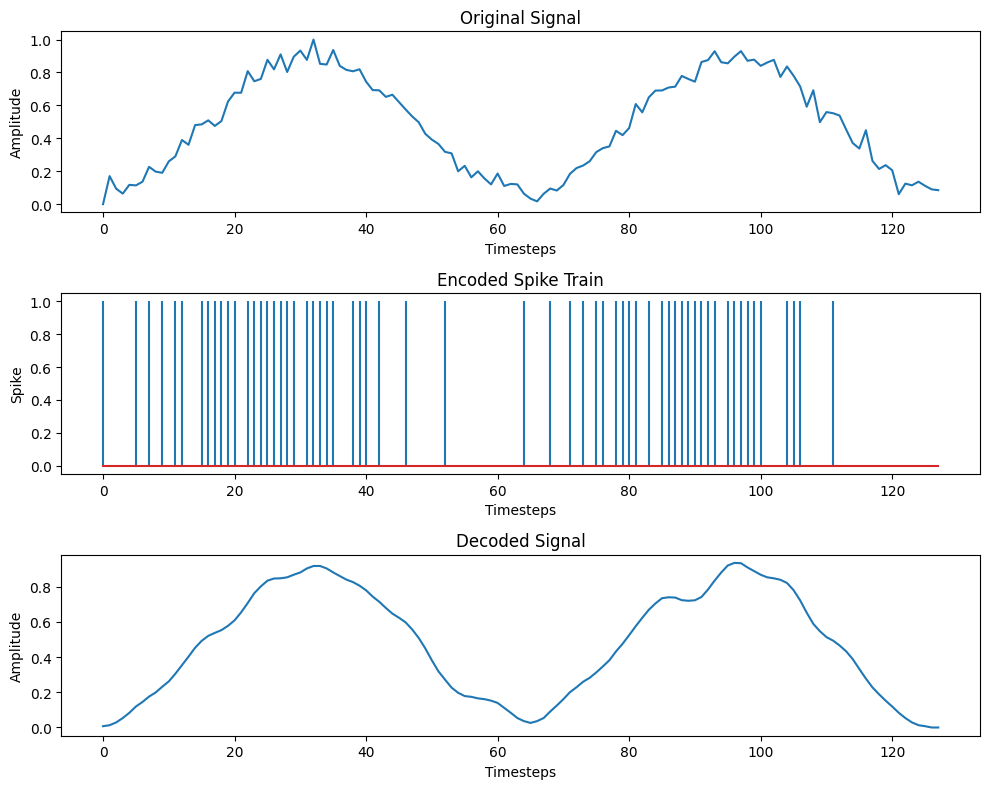

In [238]:
figs, axes = plt.subplots(3, 1, figsize=(10, 8))
figs.set_tight_layout(True)
axes[0].set_title("Original Signal")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Amplitude")
sns.lineplot(normalized_data, ax=axes[0])
axes[1].set_title("Encoded Spike Train")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Spike")
stemline = axes[1].stem(bsa_spikes, markerfmt="none")
axes[2].set_title("Decoded Signal")
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Amplitude")
sns.lineplot(bsa_decoded, ax=axes[2])

In [91]:
factor = 0.1
padding = torch.zeros_like(test_data.select(-1, 0).unsqueeze(-1))
diff = test_data.diff(dim=-1, prepend=padding)
threshold1 = torch.mean(diff, dim=-1, keepdim=True) + (torch.std(diff, dim=-1, keepdim=True) * factor)
pos_spikes = (diff > threshold1).float()
neg_spikes = (diff < -threshold1).float()
combined_spikes = pos_spikes - neg_spikes

In [92]:
decode = (combined_spikes.cumsum(dim=-1) * threshold1) + test_data.select(-1, 0).unsqueeze(-1)

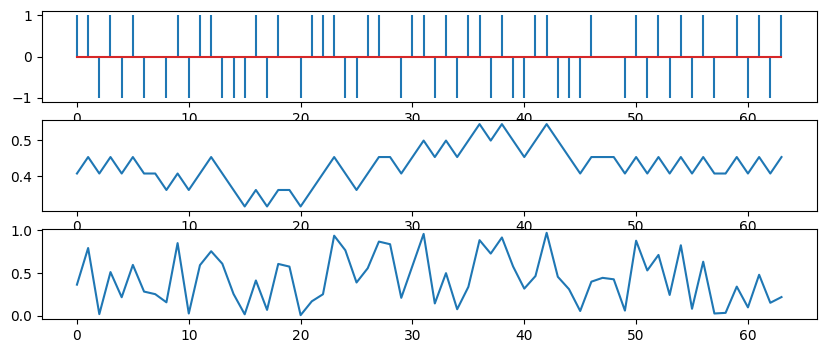

In [81]:
fig, axes = plt.subplots(3, 1, figsize=(10, 4))
axes[0].stem(combined_spikes[0, 0, 0, :], markerfmt="none")
axes[1].plot(decode[0, 0, 0, :])
axes[2].plot(test_data[0, 0, 0, :])

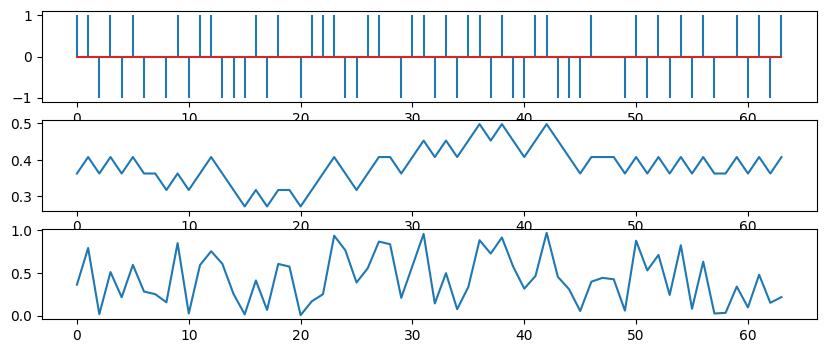

In [58]:
tbr_spikes = np.zeros_like(test_data[0,0,0,:])

data_diff = np.diff(test_data[0,0,0,:], prepend=0)
threshold = np.mean(data_diff) + 0.1 * np.std(data_diff)

for t, value in enumerate(data_diff):
    if value > threshold:
        tbr_spikes[t] = 1
    elif value < -threshold:
        tbr_spikes[t] = -1

tbr_decoded = np.zeros_like(tbr_spikes)
tbr_decoded[0] = test_data[0,0,0,:][0]
for t in range(1, len(tbr_spikes)):
    tbr_decoded[t] = tbr_decoded[t - 1] + (threshold * tbr_spikes[t])

fig, axes = plt.subplots(3, 1, figsize=(10, 4))
axes[0].stem(tbr_spikes, markerfmt="none")
axes[1].plot(tbr_decoded)
axes[2].plot(test_data[0, 0, 0, :])

In [77]:
decode[0, 0, 0, :]

tensor([0.4082, 0.4536, 0.4082, 0.4536, 0.4082, 0.4536, 0.4082, 0.4082, 0.3628,
        0.4082, 0.3628, 0.4082, 0.4536, 0.4082, 0.3628, 0.3174, 0.3628, 0.3174,
        0.3628, 0.3628, 0.3174, 0.3628, 0.4082, 0.4536, 0.4082, 0.3628, 0.4082,
        0.4536, 0.4536, 0.4082, 0.4536, 0.4991, 0.4536, 0.4991, 0.4536, 0.4991,
        0.5445, 0.4991, 0.5445, 0.4991, 0.4536, 0.4991, 0.5445, 0.4991, 0.4536,
        0.4082, 0.4536, 0.4536, 0.4536, 0.4082, 0.4536, 0.4082, 0.4536, 0.4082,
        0.4536, 0.4082, 0.4536, 0.4082, 0.4082, 0.4536, 0.4082, 0.4536, 0.4082,
        0.4536])

In [62]:
tbr_decoded

array([0.36279744, 0.40788746, 0.36279744, 0.40788746, 0.36279744,
       0.40788746, 0.36279744, 0.36279744, 0.31770742, 0.36279744,
       0.31770742, 0.36279744, 0.40788746, 0.36279744, 0.31770742,
       0.2726174 , 0.31770742, 0.2726174 , 0.31770742, 0.31770742,
       0.2726174 , 0.31770742, 0.36279744, 0.40788746, 0.36279744,
       0.31770742, 0.36279744, 0.40788746, 0.40788746, 0.36279744,
       0.40788746, 0.45297748, 0.40788746, 0.45297748, 0.40788746,
       0.45297748, 0.4980675 , 0.45297748, 0.4980675 , 0.45297748,
       0.40788746, 0.45297748, 0.4980675 , 0.45297748, 0.40788746,
       0.36279744, 0.40788746, 0.40788746, 0.40788746, 0.36279744,
       0.40788746, 0.36279744, 0.40788746, 0.36279744, 0.40788746,
       0.36279744, 0.40788746, 0.36279744, 0.36279744, 0.40788746,
       0.36279744, 0.40788746, 0.36279744, 0.40788746], dtype=float32)

In [ ]:
def tbr_encode_decode(data, factor=0.5):
    tbr_spikes = np.zeros_like(data)

    data_diff = np.diff(data)
    threshold = np.mean(data_diff) + factor * np.std(data_diff)
    data_diff = np.insert(data_diff, 0, data_diff[1])

    for t, value in enumerate(data_diff):
        if value > threshold:
            tbr_spikes[t] = 1
        elif value < -threshold:
            tbr_spikes[t] = -1

    # Decoding phase
    tbr_decoded = np.zeros_like(tbr_spikes)
    tbr_decoded[0] = data[0]
    for t in range(1, len(tbr_spikes)):
        tbr_decoded[t] = tbr_decoded[t - 1] + (threshold * tbr_spikes[t])

    return tbr_spikes, tbr_decoded

In [ ]:
def objective(trial: optuna.Trial) -> float:
    factor = trial.suggest_float("factor", 0.1, 2.0)

    _, tbr_decoded = tbr_encode_decode(normalized_data, factor=factor)

    # Calculate loss (Mean Squared Error)
    loss = np.mean((tbr_decoded - normalized_data) ** 2)
    return loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-07 01:42:21,581] A new study created in memory with name: no-name-d80975fb-a854-4df4-a63f-8bc7b4e1cb0e
[I 2025-04-07 01:42:21,582] Trial 0 finished with value: 0.3241285775537164 and parameters: {'threshold': 0.3082821065333172}. Best is trial 0 with value: 0.3241285775537164.
[I 2025-04-07 01:42:21,584] Trial 1 finished with value: 0.054688650497262806 and parameters: {'threshold': 0.09650272976771465}. Best is trial 1 with value: 0.054688650497262806.
[I 2025-04-07 01:42:21,585] Trial 2 finished with value: 0.3241285775537164 and parameters: {'threshold': 0.3925525754945972}. Best is trial 1 with value: 0.054688650497262806.
[I 2025-04-07 01:42:21,586] Trial 3 finished with value: 0.25946408906698737 and parameters: {'threshold': 0.14036135450515724}. Best is trial 1 with value: 0.054688650497262806.
[I 2025-04-07 01:42:21,587] Trial 4 finished with value: 0.3241285775537164 and parameters: {'threshold': 0.27571696537822504}. Best is trial 1 with value: 0.05468865049726280

In [ ]:
tbr_spikes, tbr_decoded = tbr_encode_decode(
    normalized_data, factor=study.best_trial.params["factor"]
)

<Axes: title={'center': 'Decoded Signal'}, xlabel='Timesteps', ylabel='Amplitude'>

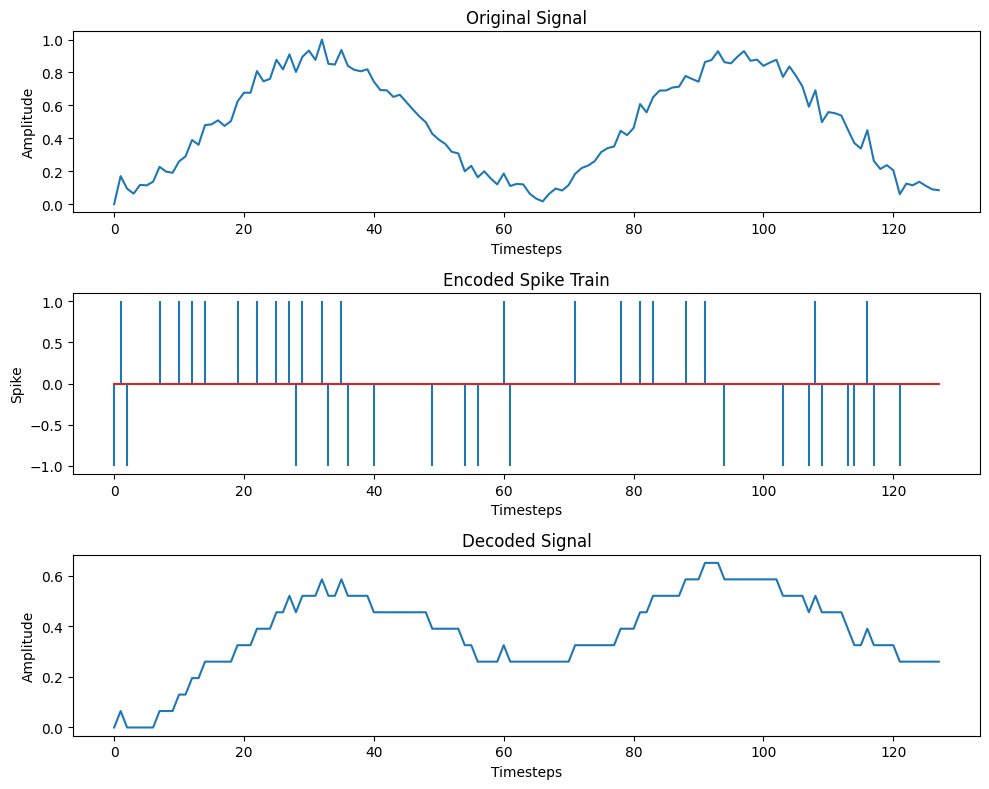

In [270]:
figs, axes = plt.subplots(3, 1, figsize=(10, 8))
figs.set_tight_layout(True)
axes[0].set_title("Original Signal")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Amplitude")
sns.lineplot(normalized_data, ax=axes[0])
axes[1].set_title("Encoded Spike Train")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Spike")
stemline = axes[1].stem(tbr_spikes, markerfmt="none")
axes[2].set_title("Decoded Signal")
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Amplitude")
sns.lineplot(tbr_decoded, ax=axes[2])